# Preprocessing: PART I

**INPUT: raw.set files**

1. Moves resting state (_RS) recordings to a separate folder (saves for later analysis, not used in this project)
2. Runs the following preproc steps on the _BL and _MAIN recordings:
    - Fixes the montage (removes mastoids; converts photodiode channel to MICS; sets 10-20 montage)
    - Detects and interpolates BAD channels using PYPREP
    - Creates EEG average reference as a projector (only created; not applied immediately)
    -> **OUTPUT: _nobads.fif file**
3. Applies band-pass filter (0.5-80 Hz)
    -> **OUTPUT: _filt.fif file**

**Proceed preprocessing using 'fixing_triggers_MAIN.ipynb' and '_BL.ipynb' files!**

In [1]:
import mne
import numpy as np
import os
import shutil
from utils import check_paths
from pyprep.find_noisy_channels import NoisyChannels
from mne.preprocessing import ICA

import matplotlib.pyplot as plt
%matplotlib qt

***Note to self:***

*- change overwrite=False and add if file exists condition for all save methods after finalising the pipeline (?)*

*- mind that some subs have different file names for the MAIN task*

50 Hz check

Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub68\s1_pac_sub68_MAIN.fdt
Reading 0 ... 1765444  =      0.000 ...  3530.888 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_24352\4260975379.py:7: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


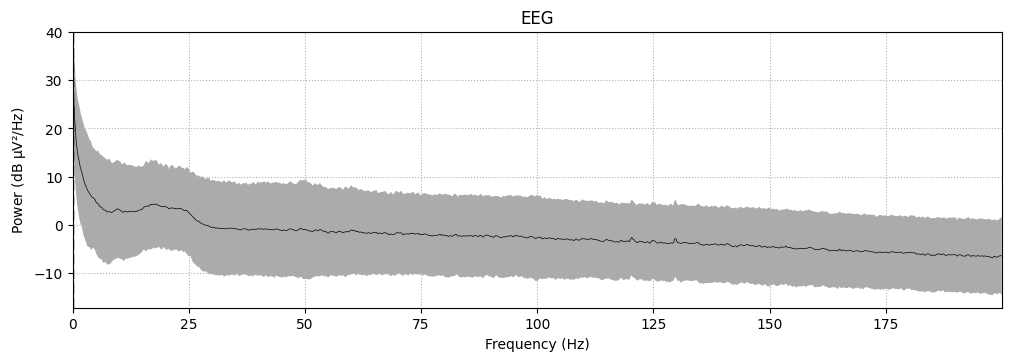

In [2]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'O' # Y or O
subs_dir = os.path.join(eeg_data_dir, group)
sub_name = 's1_pac_sub68'
task = '_MAIN'
eeg_data_path = os.path.join(eeg_data_dir, group, sub_name, f'{sub_name}{task}.set')
raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)
raw.plot_psd(fmax=200, average=True, spatial_colors=False)

1. Moving _RS files to a separate folder

In [2]:
# First, move resting state recordings to a separate folder

# Define the source directory and the destination directory
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'O' # Y or O
subs_dir = os.path.join(eeg_data_dir, group)

for sub_name in ['s1_pac_sub53', 's1_pac_sub54']: # os.listdir(subs_dir):

    source_dir = os.path.join(subs_dir, sub_name)
    rest_dir = os.path.join(source_dir, 'rest')
    check_paths(rest_dir)

    # Loop through all the files in the source directory
    for filename in os.listdir(source_dir):
        # Check if 'RS' is in the file name
        if '_RS' in filename:
            # Construct the full file paths
            source_file = os.path.join(source_dir, filename)
            destination_file = os.path.join(rest_dir, filename)

            # Move the file
            shutil.move(source_file, destination_file)

print("Files moved successfully!")

Files moved successfully!


2. Group preprocessing: part I

In [ ]:
subs = ['s1_pac2_sub43', 's1_pac_sub58', 's1_pac_sub59', 's1_pac_sub61', 's1_pac_sub63', 's1_pac_sub64', 's1_pac_sub67', 's1_pac_sub71', 's1_pac_sub72', 's1_pac_sub76', 's1_pac_sub77']

In [3]:
# PREPARE RAW RECORDINGS FOR MANUAL CHECK
tasks = ['_BL', '_MAIN']

for sub_name in ['s1_pac_sub53', 's1_pac_sub54']: # os.listdir(subs_dir): #otherwise pick subjects
    # create a preprocessing directory - ONE-TIME
    preproc_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc')
    check_paths(preproc_dir)

    for task in tasks:
        eeg_data_path = os.path.join(eeg_data_dir, group, sub_name, f'{sub_name}{task}.set')
    
        # read EEGLab file in .set format (downsampled and with powerline noise removed)
        raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)

        ############# 1. FIX MONTAGE #############
        # drop mastoid channels (as we do not record from them) 
        channels_to_drop = ['TP9', 'TP10']  # replace with actual channel names
        raw.drop_channels(channels_to_drop)

        # specify the photodiode channel to be MISC
        channels_to_change = {'BIP3': 'stim'}
        raw.set_channel_types(channels_to_change)

        # Verify the change
        print(raw.info['ch_names'])
        print(raw.get_channel_types())

        # Apply the 10-20 montage
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)
        #######################################

        ############# 2. DETECT BAD CHANNELS #############
        # Detect BAD channels with PYPREP
        # Assign the mne object to the NoisyChannels class. The resulting object will be the place where all following methods are performed
        raw_denoised = raw.copy()
        noisy_detector = NoisyChannels(raw_denoised) # call all the functions to detect bad channels.
        noisy_detector.find_all_bads()
        all_bads = noisy_detector.get_bads()
        print(all_bads)

        # Mark these channels as bad in the raw data
        raw_denoised.info['bads'].extend(all_bads)
        raw_denoised.interpolate_bads()
        #######################################

        ############# 3. SET REFERENCE: AVERAGE AS A PROJECTOR (only created; not applied immediately) #############
        # create the average reference as a projector
        raw_reref = raw_denoised.copy().set_eeg_reference("average", projection=True)
        print(raw_reref.info["projs"])
        print('Proj active:', raw_reref.proj)
        #######################################

        # save prepared files
        raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\s1_pac_sub53_BL.fdt
Reading 0 ... 171221  =      0.000 ...   342.442 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:13: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)


['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Iz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz', 'BIP3']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim']
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████|  : 68/68 [00:07<00:00,    8.58it/s]


RANSAC done!
['T8', np.str_('FT8'), 'FC1']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 57 sensor positions


Interpolating 3 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 60>]
Proj active: False
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_BL_nobads.fif


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:55: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_BL_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_BL_nobads.fif
[done]
Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\s1_pac_sub53_MAIN.fdt
Reading 0 ... 1883339  =      0.000 ...  3766.678 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:13: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)


['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Iz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz', 'BIP3']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim']
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 753/753 [01:27<00:00,    8.56it/s]



RANSAC done!
[]
Setting channel interpolation method to {'eeg': 'spline'}.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:44: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_denoised.interpolate_bads()


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 60>]
Proj active: False
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_MAIN_nobads.fif


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:55: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_MAIN_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_MAIN_nobads.fif
[done]
Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\s1_pac_sub54_BL.fdt
Reading 0 ... 164539  =      0.000 ...   329.078 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:13: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)


['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Iz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz', 'BIP3']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim']
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 65/65 [00:07<00:00,    9.08it/s]


RANSAC done!
[np.str_('F8'), 'FC2', 'FC1']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 57 sensor positions


Interpolating 3 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 60>]
Proj active: False
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_BL_nobads.fif
Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_BL_nobads.fif
[done]


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:55: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_BL_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)


Reading D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\s1_pac_sub54_MAIN.fdt
Reading 0 ... 1991855  =      0.000 ...  3983.710 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:13: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)


['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Iz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz', 'BIP3']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim']
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 796/796 [01:29<00:00,    8.89it/s]


RANSAC done!
[np.str_('F8'), 'FC2', 'FC1']
Setting channel interpolation method to {'eeg': 'spline'}.


Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 57 sensor positions
Interpolating 3 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 60>]
Proj active: False
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_MAIN_nobads.fif


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\4235717396.py:55: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_MAIN_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_MAIN_nobads.fif
[done]


3. Band-pass filtering

In [7]:
############# BANDPASS FILTERING #############

for sub_name in ['s1_pac_sub53', 's1_pac_sub54']: # os.listdir(subs_dir):
    preproc_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc')

    # create a directory for ICA files
    filt_dir = os.path.join(preproc_dir, 'filt')
    check_paths(filt_dir)

    for task in tasks:

        eeg_data_path = os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif')

        #  read EEGLab file in .set format (downsampled and with powerline noise removed)
        raw_nobads = mne.io.read_raw_fif(eeg_data_path, preload=True)

        # apply 0.5-80 Hz filtering
        raw_filt = raw_nobads.copy().filter(
                                    l_freq=0.5, h_freq=80, 
                                    picks=['eeg'], method='fir', 
                                    fir_window='hamming')

        # save filtered files
        raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt.fif'), overwrite=True)
        print(f'{sub_name}: Filtered file saved successfully as {sub_name}{task}_filt.fif!')
        
        raw_filt.plot_psd(fmax=200, average=True, spatial_colors=False) # check the PSD


Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_BL_nobads.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 171221 =      0.000 ...   342.442 secs
Ready.
Reading 0 ... 171221  =      0.000 ...   342.442 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 3301 samples (6.602 s)



C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:15: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_BL_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_nobads = mne.io.read_raw_fif(eeg_data_path, preload=True)


Overwriting existing file.
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\filt\s1_pac_sub53_BL_filt.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:24: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\filt\s1_pac_sub53_BL_filt.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\filt\s1_pac_sub53_BL_filt.fif
[done]
s1_pac_sub53: Filtered file saved successfully as s1_pac_sub53_BL_filt.fif!
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_MAIN_nobads.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 1883339 =      0.000 ...  3766.678 secs
Ready.
Reading 0 ... 1883339  =      0.000 ...  3766.678 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:15: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\s1_pac_sub53_MAIN_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_nobads = mne.io.read_raw_fif(eeg_data_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Overwriting existing file.
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\filt\s1_pac_sub53_MAIN_filt.fif


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:24: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\filt\s1_pac_sub53_MAIN_filt.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub53\preproc\filt\s1_pac_sub53_MAIN_filt.fif
[done]
s1_pac_sub53: Filtered file saved successfully as s1_pac_sub53_MAIN_filt.fif!
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_BL_nobads.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 164539 =      0.000 ...   329.078 secs
Ready.
Reading 0 ... 164539  =      0.000 ...   329.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:15: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_BL_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_nobads = mne.io.read_raw_fif(eeg_data_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Overwriting existing file.
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\filt\s1_pac_sub54_BL_filt.fif
Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\filt\s1_pac_sub54_BL_filt.fif
[done]
s1_pac_sub54: Filtered file saved successfully as s1_pac_sub54_BL_filt.fif!
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:24: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\filt\s1_pac_sub54_BL_filt.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt.fif'), overwrite=True)


Plotting power spectral density (dB=True).
Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_MAIN_nobads.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 1991855 =      0.000 ...  3983.710 secs
Ready.
Reading 0 ... 1991855  =      0.000 ...  3983.710 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:15: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\s1_pac_sub54_MAIN_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_nobads = mne.io.read_raw_fif(eeg_data_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Overwriting existing file.
Writing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\filt\s1_pac_sub54_MAIN_filt.fif


C:\Users\a1902989\AppData\Local\Temp\ipykernel_4748\3871683211.py:24: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\filt\s1_pac_sub54_MAIN_filt.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\O\s1_pac_sub54\preproc\filt\s1_pac_sub54_MAIN_filt.fif
[done]
s1_pac_sub54: Filtered file saved successfully as s1_pac_sub54_MAIN_filt.fif!
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


**FINAL FILE PATH:**

sub_dir -> preproc -> filt -> '{sub_name}{task}_filt.fif'

_____________________________

STOP HERE

In [ ]:
# MANUAL CHECK: mark noisy segments (one sub at a time) - hit A, pick BADS and mark the segments.
#! Close the menu first, then close the plot

# finished: ['s1_pac_sub01']
# to go: ['s1_pac_sub05', 's1_pac_sub07', 's1_pac_sub10', 's1_pac_sub11', 's1_pac_sub16', 's1_pac_sub19',
#         's1_pac_sub22', 's1_pac_sub24', 's1_pac_sub26', 's1_pac_sub28', 's1_pac_sub29',
#         's1_pac_sub32', 's1_pac_sub33', 's1_pac_sub38', 's1_pac_sub66', 's1_sub04_KS', 's1_sub06_MAP']

sub_name = 's1_pac_sub01' # specify the subject you want to analyse
preproc_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc')
filt_dir = os.path.join(preproc_dir, 'filt')
tasks = ['_BL', '_MAIN']

for task in tasks:
    eeg_data_path = os.path.join(filt_dir, f'{sub_name}{task}_filt.fif')

    raw_filt = mne.io.read_raw_fif(eeg_data_path, preload=True)
    raw_filt.plot(block=True)
    plt.show()  # Blocks execution until the plot window is closed

    # save filtered file
    raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_clean.fif'), overwrite=True)



________________

ICA

In [ ]:
# ICA

tasks = ['_BL', '_MAIN']

for sub_name in ['s1_pac_sub01']: # os.listdir(subs_dir):
    preproc_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc')

    # create a directory for ICA files
    ica_dir = os.path.join(preproc_dir, 'ICA')
    check_paths(ica_dir)

    for task in tasks:

        eeg_data_path = os.path.join(preproc_dir, f'{sub_name}{task}_clean.fif')

        #################################################################################
        # apply ICA
        ica = ICA(n_components=None, max_iter="auto")
        ica.fit(raw_filt)

        # plot and save the ICA components
        fig_components = ica.plot_components()

        for i, fig in enumerate(fig_components):
            fig.savefig(os.path.join(ica_dir, f'{sub_name}{task}_ica_components_{i}.png'))
            plt.close(fig)  # Close the figure after saving to avoid display

        ica.save(os.path.join(ica_dir, f'{sub_name}{task}_ica.fif'))


Manual check for BAD components

In [ ]:
# MANUAL CHECK: pick ICA components to exclude
# When ICA sources are plotted, look at the ICA topography in parallel to decide which ICA component s to exclude
# TO EXCLUDE A COMPONENT: right-click on it (should turn grey) -> close the figure -> check after saving

sub_name = 's1_pac_sub00' # specify the subject you want to analyse

for task in tasks:
    eeg_data_path = os.path.join(filt_dir, f'{sub_name}{task}_filt.fif')

    reconst_raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)

    # plot ICA sources
    ica.plot_sources(raw_filt)
    plt.show()  # Blocks execution until the plot window is closed

    # ica.exclude = [0]
    ica.apply(reconst_raw)

    # save ICA with excluded components and reconstructed file
    ica.save(os.path.join(ica_dir, f'{sub_name}{task}_ica_excl.fif'), overwrite=True)
    reconst_raw.save(os.path.join(ica_dir, f'{sub_name}{task}_reconst.fif'), overwrite=True) # FINAL FILE

__________

**DIRTY FIELD: Single subj preproc - draft**

In [34]:
# set EEG data path, group, task and subject
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
sub_name = 's1_pac_sub01'
task = '_MAIN' # '_RS_OE', '_RS_CE', '_BL', '_MAIN'
eeg_data_path = os.path.join(eeg_data_dir, group, sub_name, f'{sub_name}{task}.set')
eeg_data_path


'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\s1_pac_sub01_MAIN.set'

In [35]:
# create a preprocessing directory - ONE-TIME
preproc_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc')
check_paths(preproc_dir)

In [36]:
# read EEGLab file in .set format (downsampled and with powerline noise removed)
raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)
raw

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\s1_pac_sub01_MAIN.fdt
Reading 0 ... 1575850  =      0.000 ...  3151.700 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_29400\441035637.py:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_data_path, preload=True)


<RawEEGLAB | s1_pac_sub01_MAIN.fdt, 63 x 1575851 (3151.7 s), ~757.5 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 4.096 (s)


C:\Users\a1902989\AppData\Local\Temp\ipykernel_29400\2231872650.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne.viz.plot_raw_psd(raw)


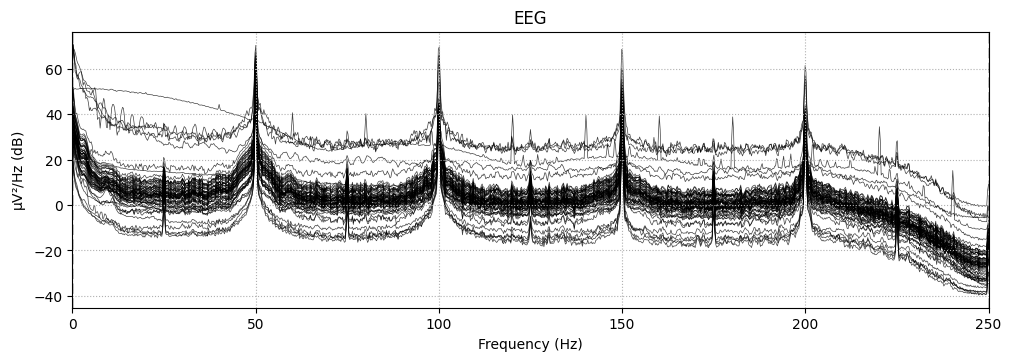

In [16]:
mne.viz.plot_raw_psd(raw)

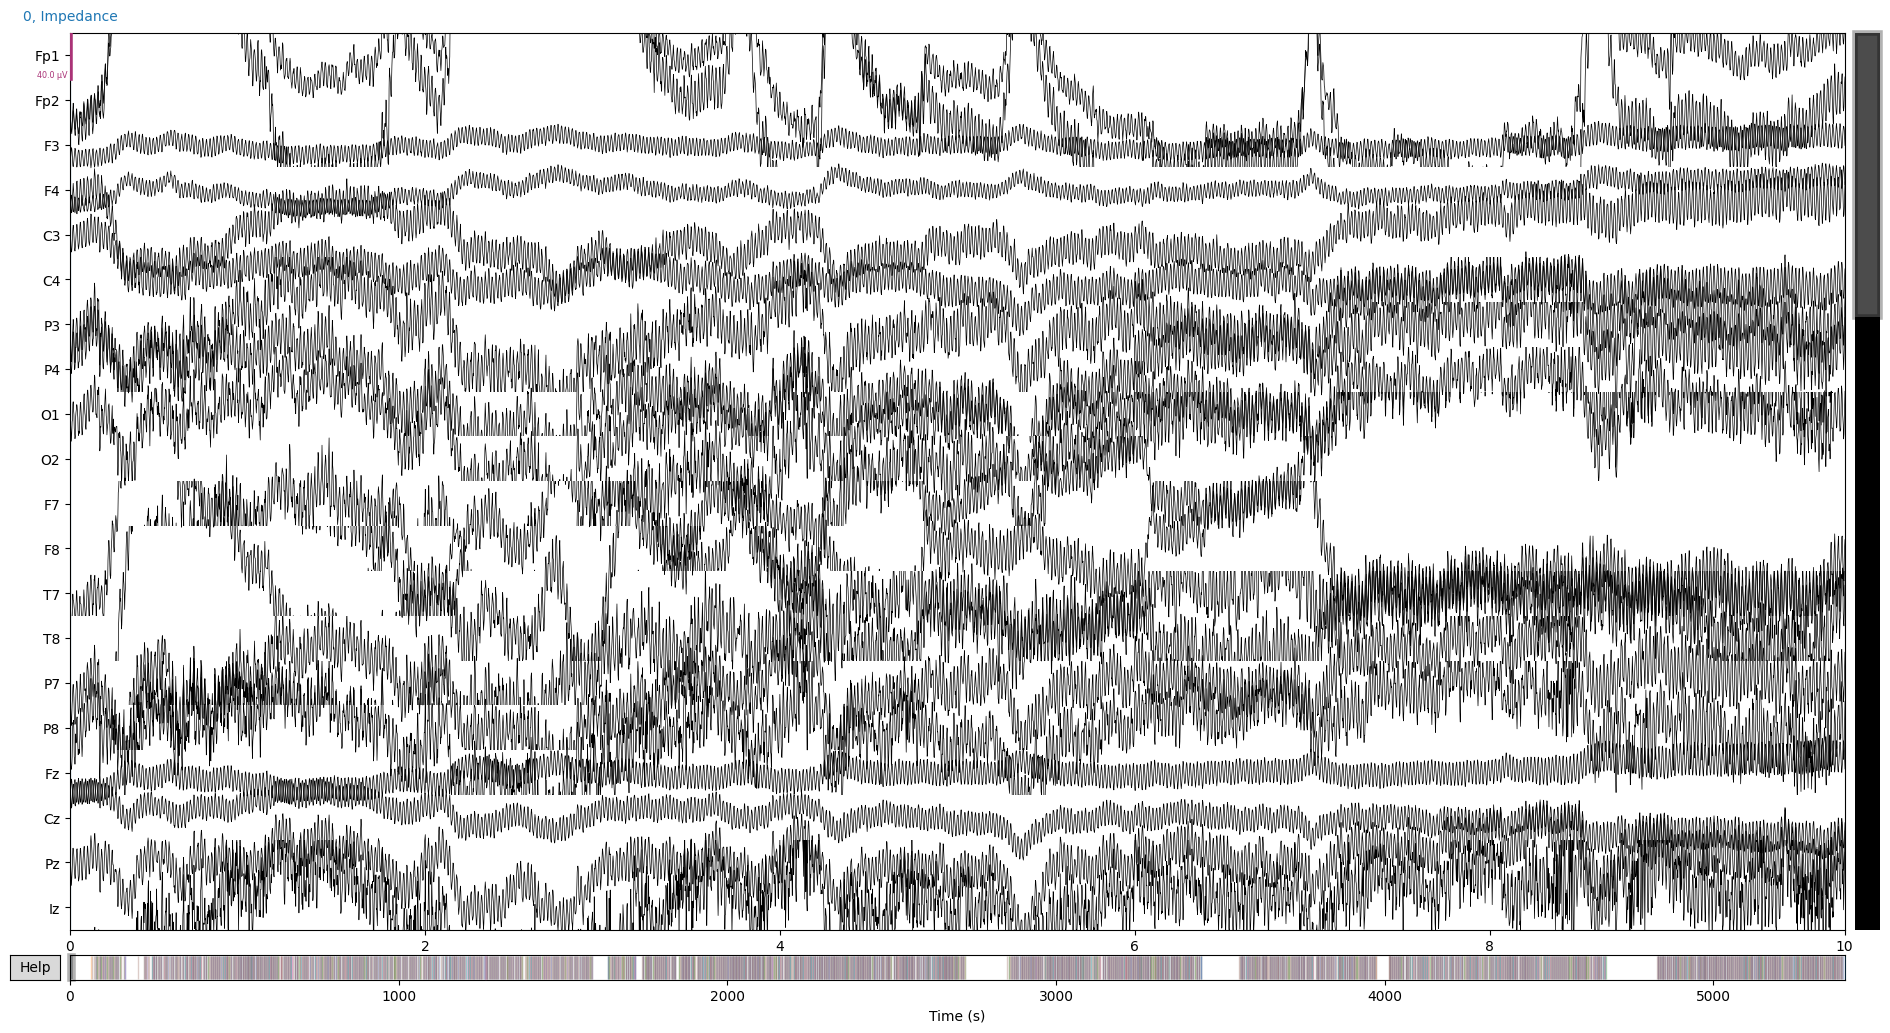

In [17]:
raw.plot()

In [37]:
# drop mastoid channels (as we do not record from them) 
channels_to_drop = ['TP9', 'TP10']  # replace with actual channel names
raw.drop_channels(channels_to_drop)

# specify the photodiode channel to be MISC
channels_to_change = {'BIP3': 'misc'}
raw.set_channel_types(channels_to_change)

# Verify the change
print(raw.info['ch_names'])
print(raw.get_channel_types())

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Iz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz', 'BIP3']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc']


C:\Users\a1902989\AppData\Local\Temp\ipykernel_29400\3126568557.py:7: RuntimeWarning: The unit for channel(s) BIP3 has changed from V to NA.
  raw.set_channel_types(channels_to_change)


Using matplotlib as 2D backend.


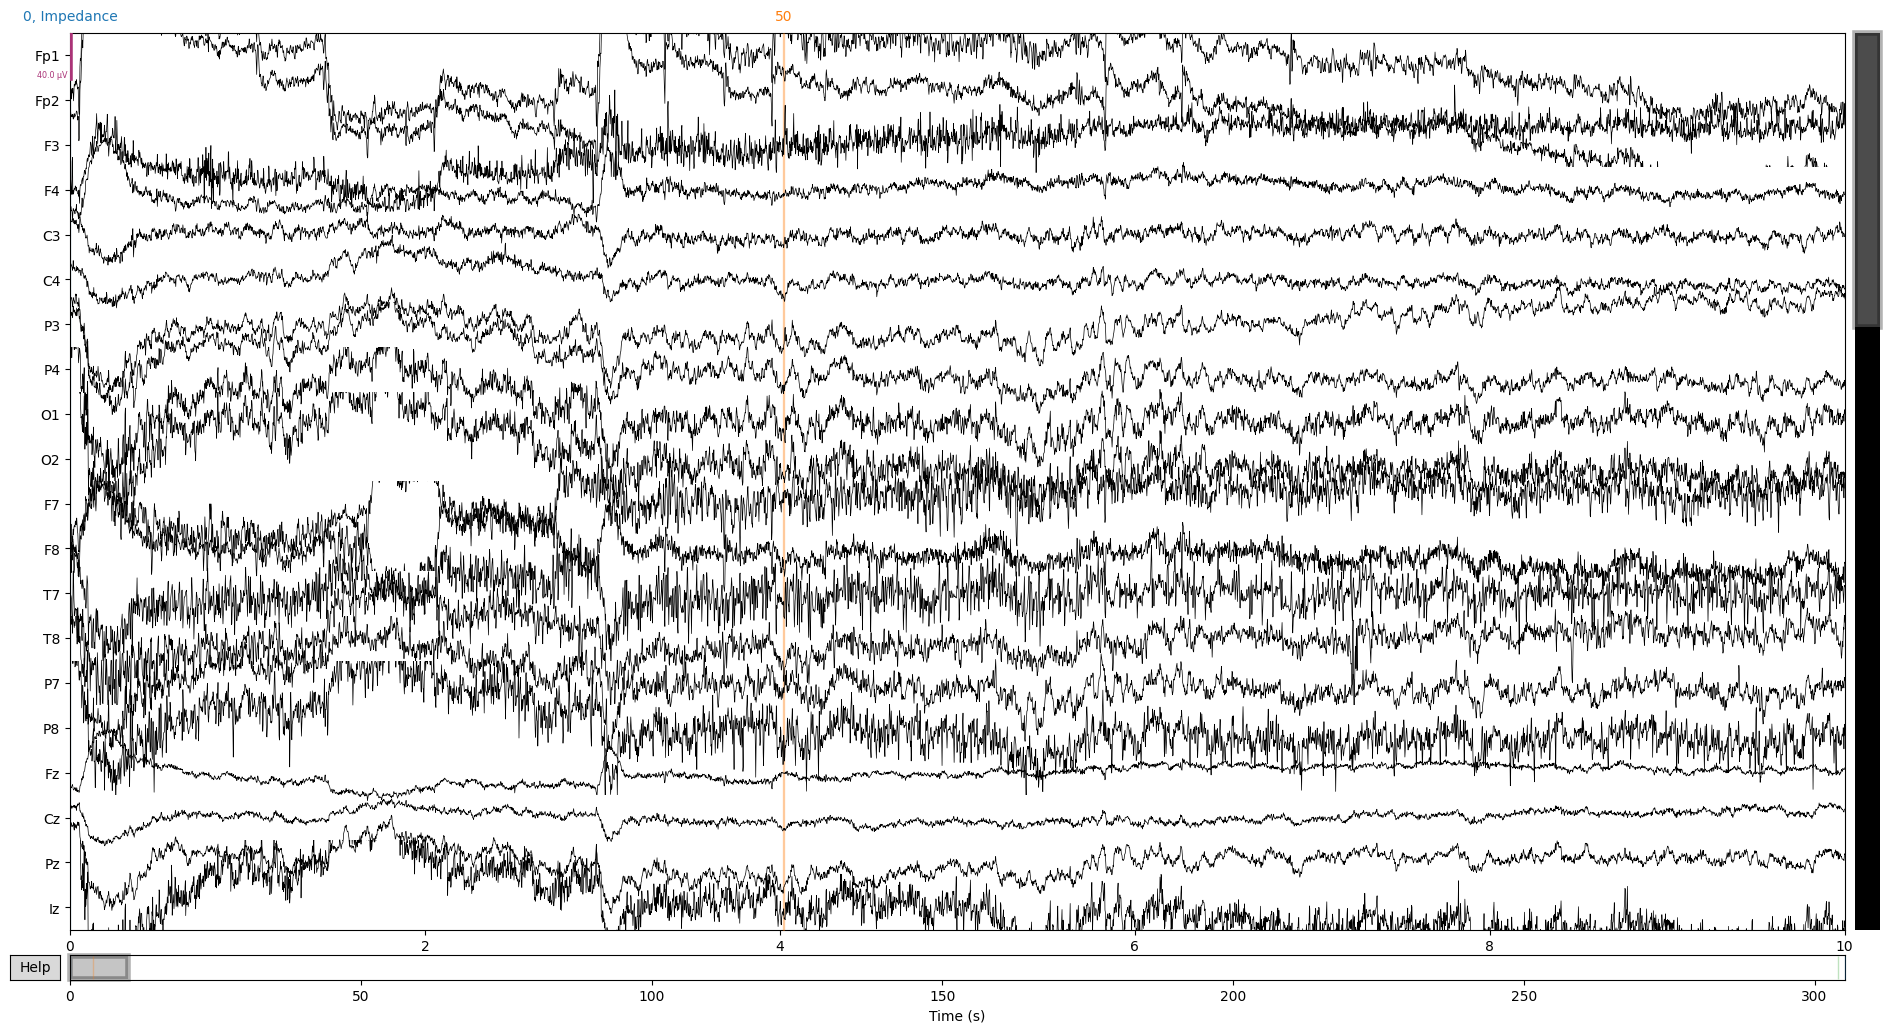

In [7]:
# OPTIONAL
#  sanity check (powerline noise and raw data)
# fig = raw.compute_psd().plot(average=True)
raw.plot()

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


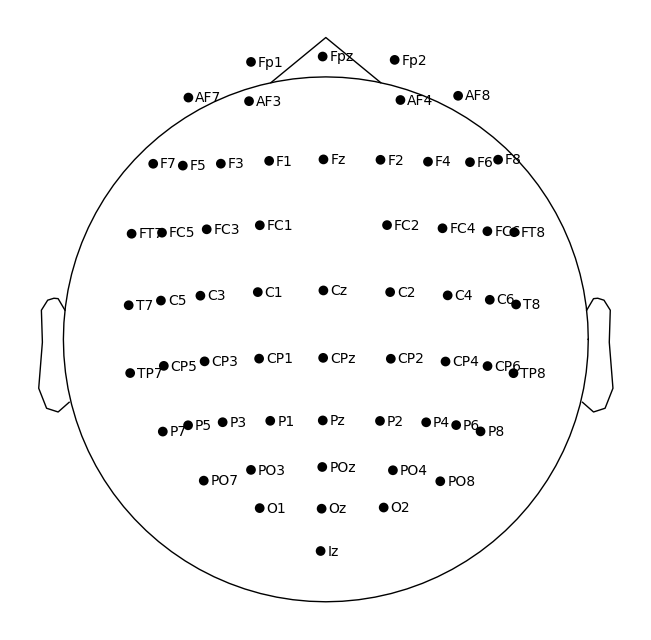

In [38]:
# Apply the 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

montage.plot(kind='3d') # optional
raw.plot_sensors(kind='topomap', show_names=True) # optional

In [39]:
# Detect BAD channels with PYPREP
# Assign the mne object to the NoisyChannels class. The resulting object will be the place where all following methods are performed
raw_denoised = raw.copy()
noisy_detector = NoisyChannels(raw_denoised) # call all the functions to detect bad channels.
noisy_detector.find_all_bads()
all_bads = noisy_detector.get_bads()
print(all_bads)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 630/630 [01:11<00:00,    8.84it/s]


RANSAC done!
['F3', 'F5', 'FC2']


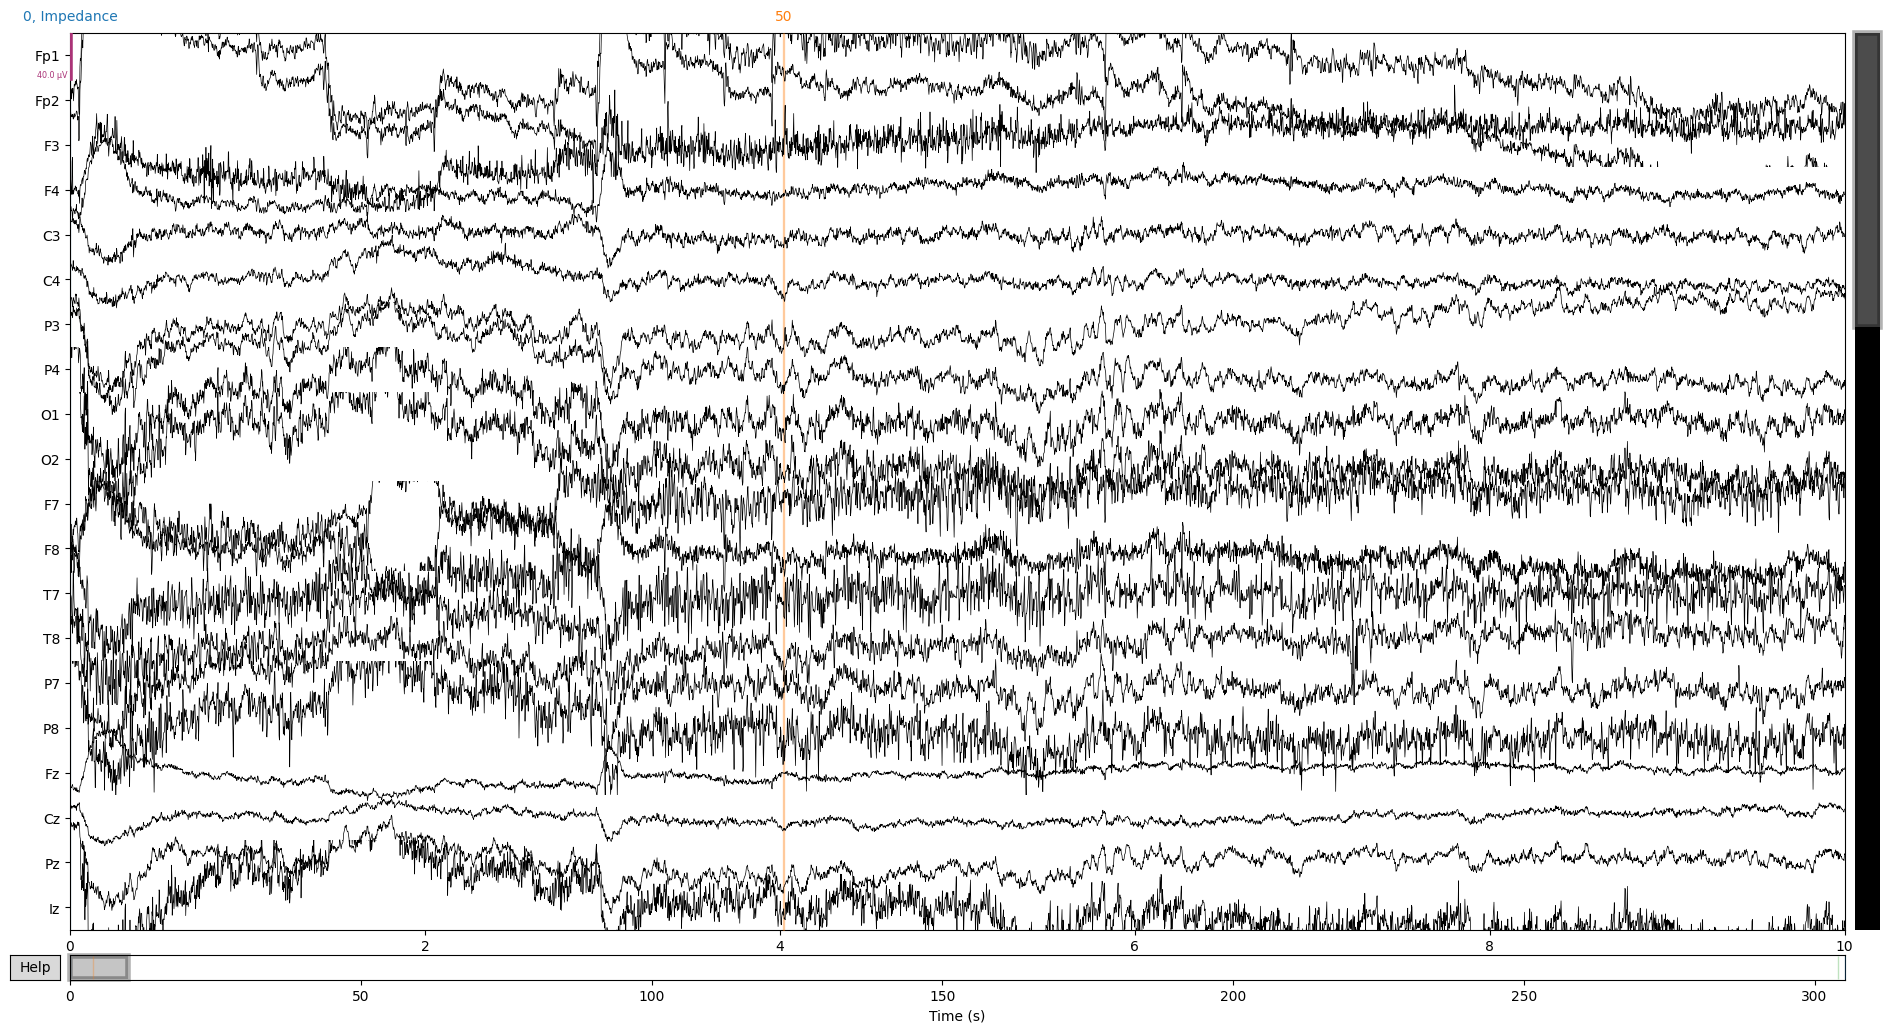

In [51]:
raw.plot()

In [40]:
# Mark these channels as bad in the raw data
raw_denoised.info['bads'].extend(all_bads)
# raw_denoised.plot() # check before interpolation

raw_denoised.interpolate_bads()
# raw_denoised.plot() # check after interpolation

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 57 sensor positions
Interpolating 3 sensors


<RawEEGLAB | s1_pac_sub01_MAIN.fdt, 61 x 1575851 (3151.7 s), ~733.5 MB, data loaded>

In [41]:
# create the average reference as a projector
raw_reref = raw_denoised.copy().set_eeg_reference("average", projection=True)
print(raw_reref.info["projs"])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 60>]


In [15]:
# check if the projections are active (should be off) -> the projections will be automatically applied when the data is epoched
print('Proj active:', raw_reref.proj)
print('Proj active:', raw_reref.info["projs"][0]['active'])

Proj active: False
Proj active: False


In [42]:
raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)

Writing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_MAIN_nobads.fif


C:\Users\a1902989\AppData\Local\Temp\ipykernel_29400\3442260501.py:1: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_MAIN_nobads.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_reref.save(os.path.join(preproc_dir, f'{sub_name}{task}_nobads.fif'), overwrite=True)


Closing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_MAIN_nobads.fif
[done]


Bad segments

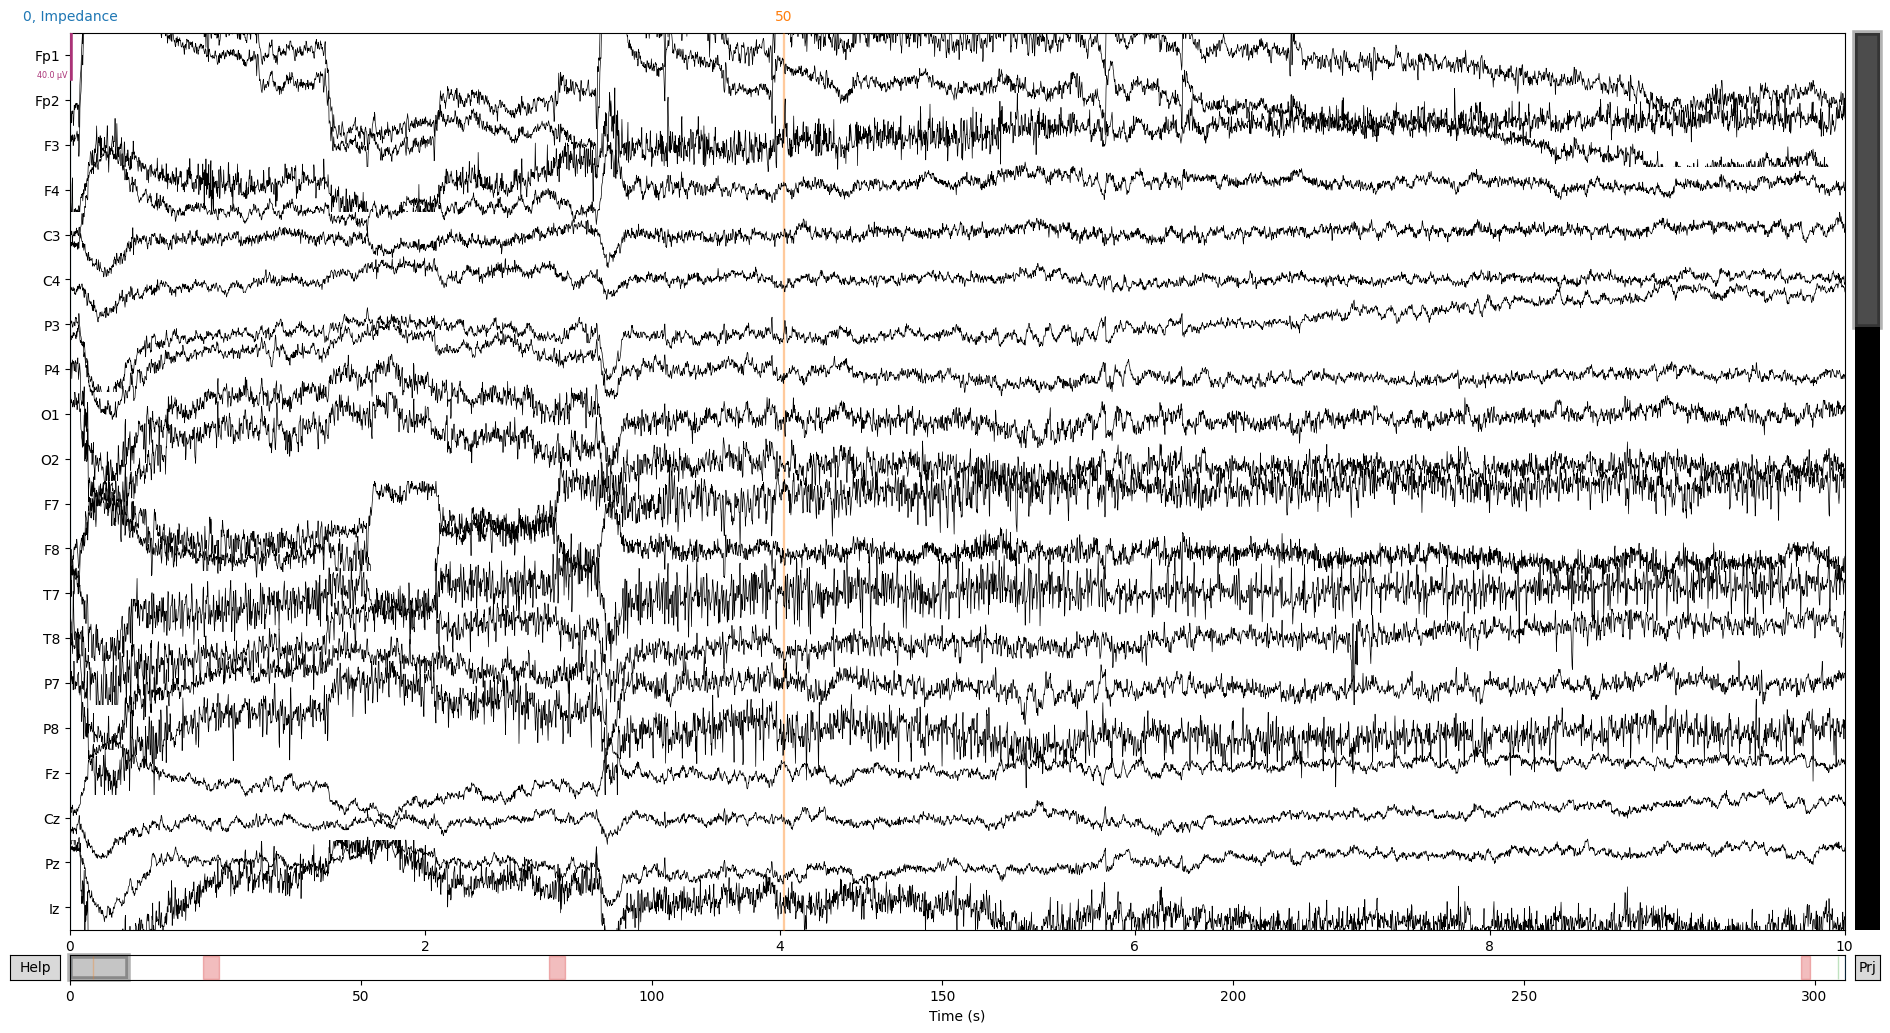

In [17]:
# MANUAL CHECK: mark noisy segments
raw_reref.plot()

Bandpass filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


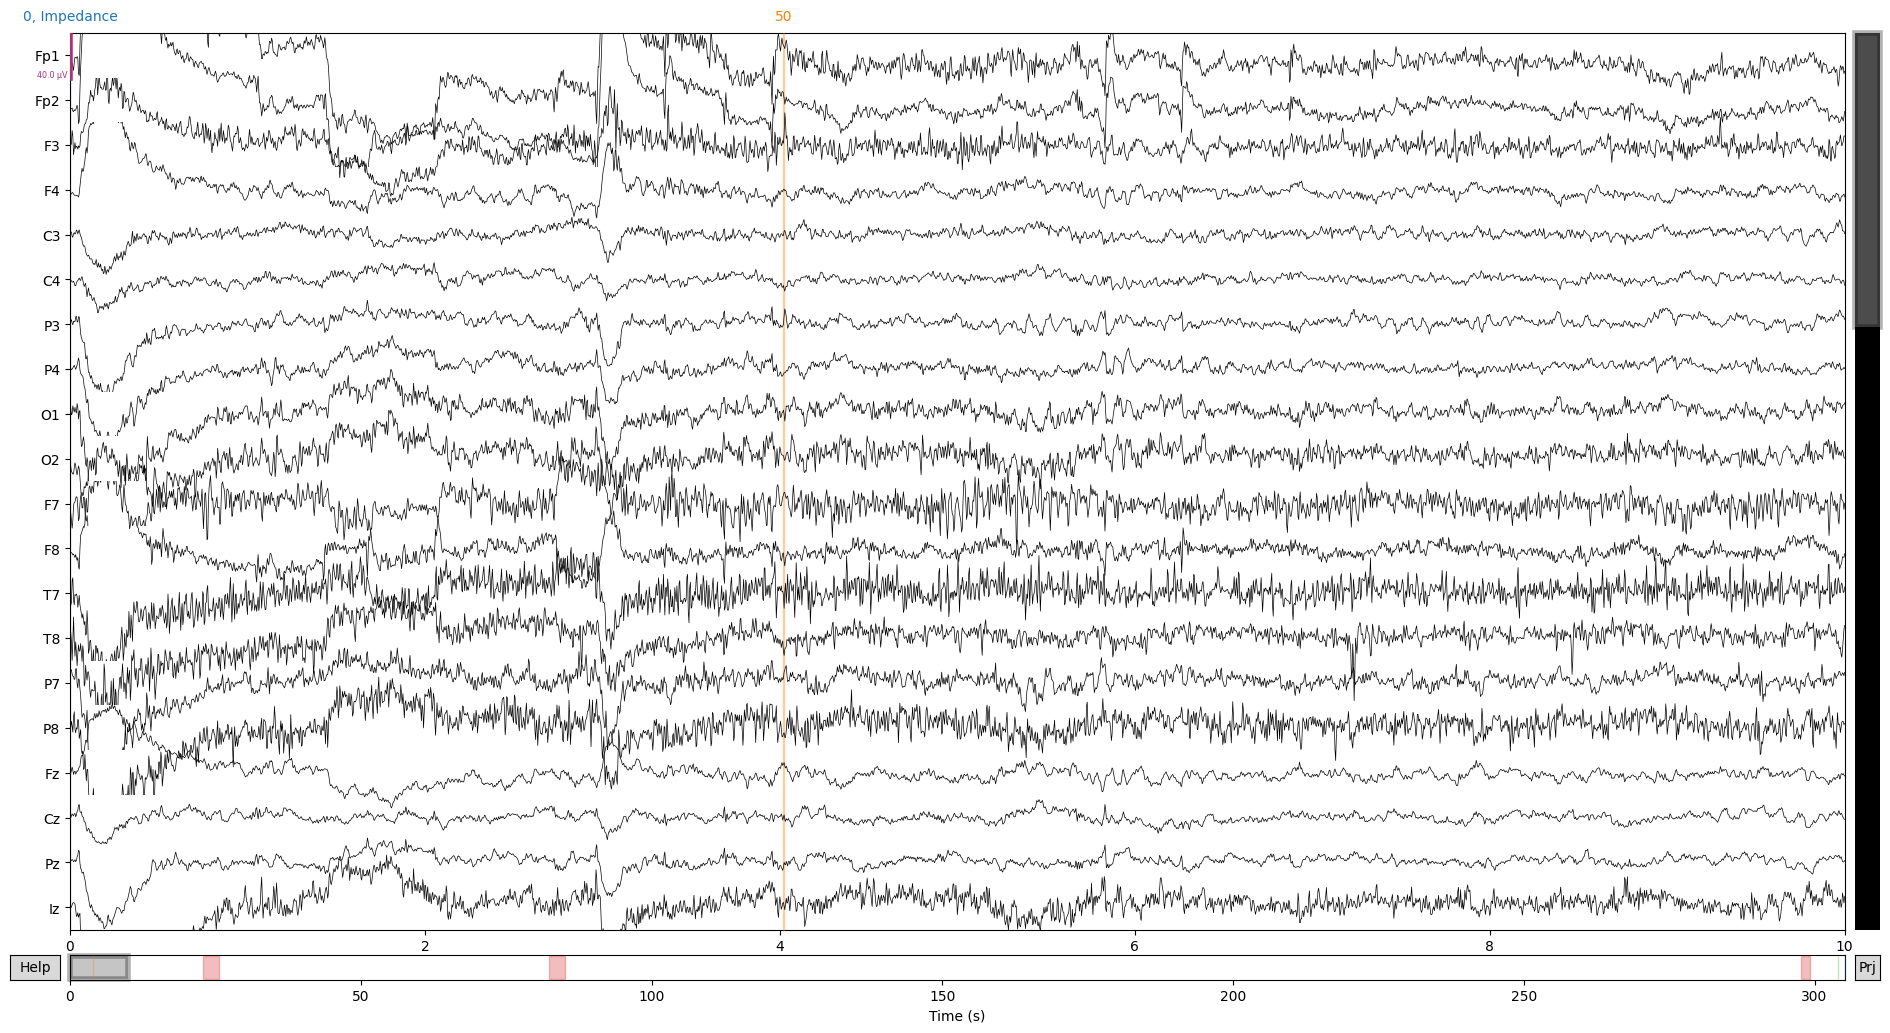

In [18]:
raw_filt = raw_reref.copy().filter(
                            l_freq=0.5, h_freq=80, 
                            picks=['eeg'], method='fir', 
                            fir_window='hamming')
raw_filt.plot()

*ICA*

In [28]:
reconst_raw = raw_filt.copy()

ica = ICA(n_components=None, max_iter="auto")
ica.fit(raw_filt)
ica

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Omitting 3457 of 152618 (2.27%) samples, retaining 149161 (97.73%) samples.
Selecting by non-zero PCA components: 60 components
Fitting ICA took 375.7s.


d:\BonoKat\research project\# study 1\venv\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<ICA | raw data decomposition, method: fastica (fit in 1000 iterations on 149161 samples), 60 ICA components (60 PCA components available), channel types: eeg, no sources marked for exclusion>

In [ ]:
# Plot ICA sources, plot and save the ICA components
path_to_save = os.path.join(sub_name, task, preproc_dir)

ica.plot_sources(raw_filt)
fig_components = ica.plot_components()

for i, fig in enumerate(fig_components):
    fig.savefig(os.path.join(preproc_dir, f'{sub_name}{task}_ica_components_{i}.png'))
    plt.close(fig)  # Close the figure after saving to avoid display

In [24]:
# MANUAL CHECK: For all recordings except RS_CE pick the components to exclude
ica.exclude = [0]
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components


<RawEEGLAB | s1_pac_sub01_RS_OE.fdt, 61 x 152618 (305.2 s), ~71.1 MB, data loaded>

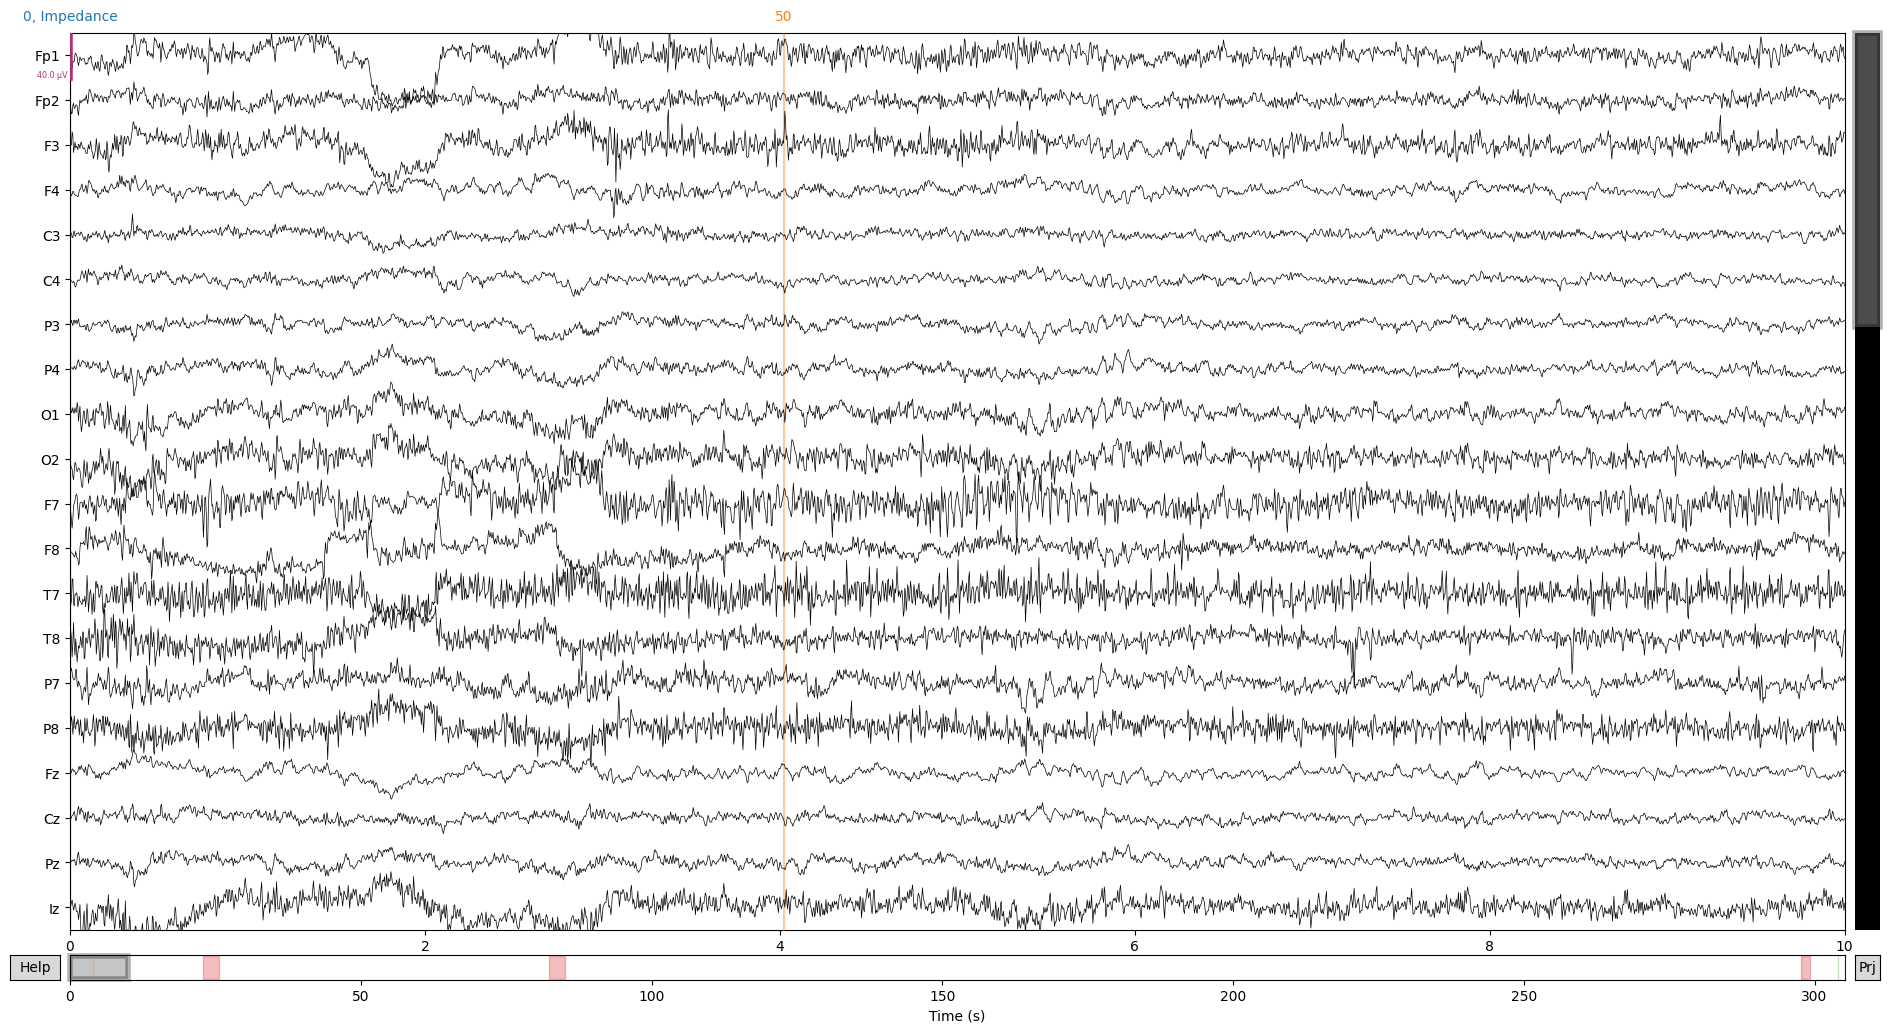

In [25]:
# compare pre and post ICA data
raw_filt.plot()
reconst_raw.plot()

In [26]:
reconst_raw.save(os.path.join(preproc_dir, f'{sub_name}{task}_preproc.fif'), overwrite=True)

Overwriting existing file.
Writing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_RS_OE_preproc.fif
Closing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_RS_OE_preproc.fif
[done]


C:\Users\a1902989\AppData\Local\Temp\ipykernel_17636\2049712322.py:1: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_RS_OE_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw.save(os.path.join(preproc_dir, f'{sub_name}{task}_preproc.fif'), overwrite=True)


In [27]:
# sanity check (OPTIONAL)
raw_check = mne.io.read_raw_fif(os.path.join(preproc_dir, f'{sub_name}{task}_preproc.fif'), preload=True)
raw_check.plot()
raw_check

Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_RS_OE_preproc.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 152617 =      0.000 ...   305.234 secs
Ready.
Reading 0 ... 152617  =      0.000 ...   305.234 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_17636\3025986153.py:2: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\s1_pac_sub01_RS_OE_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_check = mne.io.read_raw_fif(os.path.join(preproc_dir, f'{sub_name}{task}_preproc.fif'), preload=True)


<Raw | s1_pac_sub01_RS_OE_preproc.fif, 61 x 152618 (305.2 s), ~71.1 MB, data loaded>